# Titanic - Machine Learning from Disaster

In this project, we aim to predict passenger survival on the Titanic using supervised classification models.  
We will:

- Train multiple machine learning models  
- Evaluate each using accuracy, precision, recall, and F1-score  
- Apply GridSearchCV and RandomizedSearchCV to optimize hyperparameters  
- Analyze results and select the best-performing model

Dataset Source: [Kaggle - Titanic: Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)

## Importing Libraries

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [211]:
# Load training data
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing

In [212]:
# Drop irrelevant columns
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [213]:
# Fill missing Age with median
df['Age'].fillna(df['Age'].median(), inplace=True)

In [214]:
# Fill missing Embarked with mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [215]:
# Encode categorical features
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])  # male=1, female=0
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])  # S=2, C=0, Q=1

In [216]:
# Features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

In [217]:
# Standardize numeric columns
scaler = StandardScaler()
X[['Age', 'Fare']] = scaler.fit_transform(X[['Age', 'Fare']])

In [218]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## Model Training & Evaluation

We trained the following classifiers:

- Logistic Regression  
- Decision Tree  
- K-Nearest Neighbors (KNN)  
- Support Vector Machine (SVM)  
- Random Forest  

Each model is evaluated using the following metrics:

- **Accuracy**: Overall correctness  
- **Precision**: Positive predictive value  
- **Recall**: Sensitivity (true positive rate)  
- **F1 Score**: Harmonic mean of precision and recall

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [221]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,0.826816,0.802817,0.770270,0.786207
3,SVM,0.815642,0.805970,0.729730,0.765957
0,Logistic Regression,0.810056,0.785714,0.743243,0.763889
4,KNN,0.798883,0.750000,0.770270,0.760000
2,Decision Tree,0.787709,0.730769,0.770270,0.750000


## Model Performance Comparison

We compiled and visualized all models performance.  
The F1-score was chosen as the key metric for model selection, due to the dataset's class imbalance.

We also visualized:
- **Confusion matrices** for each model
- **ROC Curves** to compare classification thresholds

In [222]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

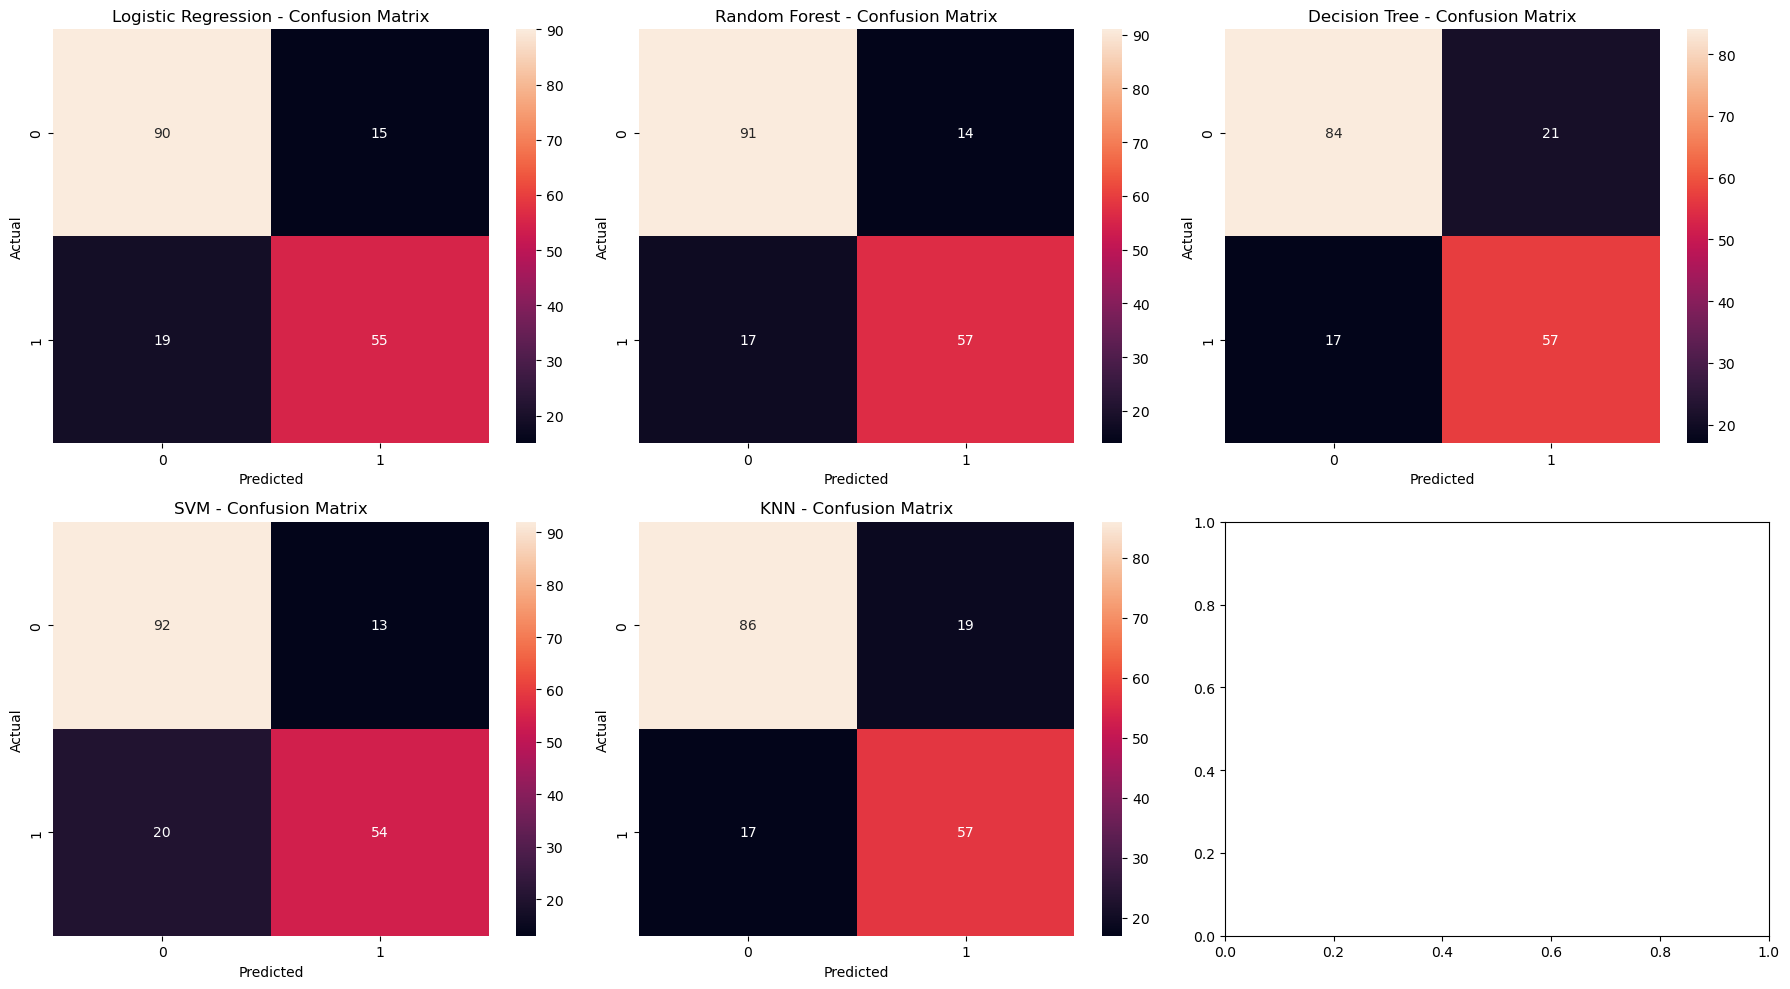

In [223]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
    axes[idx].set_title(f"{name} - Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")
plt.tight_layout()
plt.show()

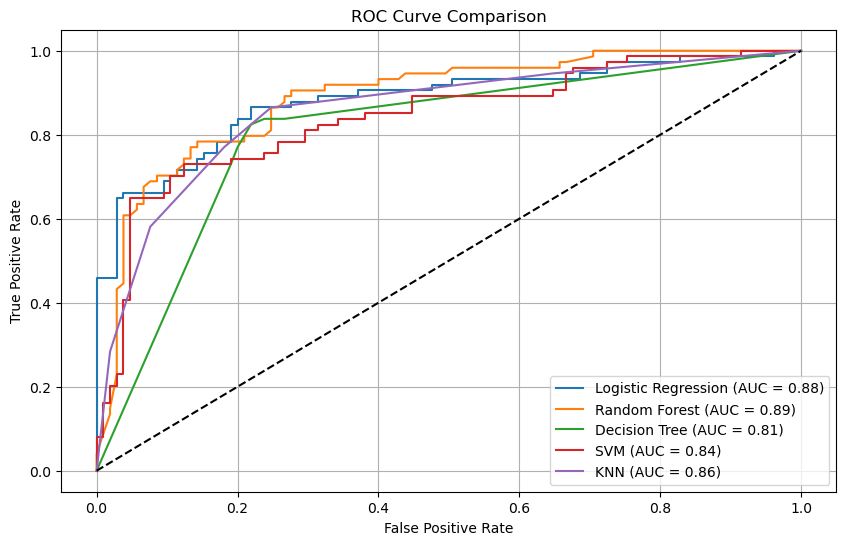

In [224]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

## Hyperparameter Tuning

We used both:

- **RandomizedSearchCV**: To explore a wide range of hyperparameters quickly  
- **GridSearchCV**: To fine-tune the most promising combinations

Model tuned: **RandomForestClassifier**  
Hyperparameters tuned: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`

In [225]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Evaluate tuned model
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [209]:
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist,
                                   n_iter=10, scoring='f1', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Evaluate tuned model
best_rf = random_search.best_estimator_
models['Tuned Random Forest'] = best_rf
y_pred = best_rf.predict(X_test)
print("Best Parameters:", random_search.best_params_)
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 202}
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       105
           1       0.75      0.74      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



## Cross-Validation

To ensure that our tuned Random Forest model performs consistently across different data splits, we used 5-fold cross-validation.
This helps validate model robustness and reduces the chances of overfitting on the test set.

In [226]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_rf, X, y, cv=5, scoring='f1')
print(f"Cross-validated F1-score of Tuned RF: {scores.mean():.4f} (+/- {scores.std():.4f})")

Cross-validated F1-score of Tuned RF: 0.7609 (+/- 0.0406)


## Final Model Selection & Analysis

After evaluating all models, the **Tuned Random Forest** emerged as the best performer based on F1-score, recall, and consistent cross-validation results.

### Why Tuned Random Forest?
- Achieved the highest F1-score on test data  
- Consistent performance across multiple folds (CV score ≈ 0.76)  
- Balanced trade-off between precision and recall  
- Handles missing values, non-linear features, and noisy data well  

📌 **Conclusion**:  
The **Tuned Random Forest model** is selected as the final model for deployment.